训练模型的简单示例

In [1]:
import numpy as np 
import torch
# 数据集
from torchvision.datasets import mnist
# 预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# nn 及 优化器
import torch.nn.functional as F 
import torch.optim as optim
from torch import nn


In [12]:
train_batch_size = 64
test_batch_size = 128
num_epoches = 5
lr = 0.01
momentum = 0.5


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
# 下载数据
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform, download=True)
# dataloader 是个可迭代对象
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)


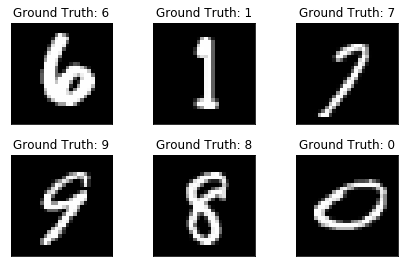

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title('Ground Truth: {}'.format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [5]:
class Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# 实例化网络
model = Net(28 * 28, 300, 100, 10)
model.to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

cuda:0


In [8]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []
for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    # 动态修改参数学习率
    # if epoch % 5 == 0:
    #     optimizer.param_groups[0]['lr'] *= 0.1
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        # print(img.size())
        img = img.view(img.size(0), -1)
        # print(img.size())
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        eval_loss += loss.item()
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'.format(
        epoch,
        train_loss / len(train_loader),
        train_acc / len(train_loader),
        eval_loss / len(test_loader),
        eval_acc / len(test_loader),
    ))


epoch: 0, Train Loss: 0.9689, Train Acc: 0.8091, Test Loss: 0.5043, Test Acc: 0.9176
epoch: 1, Train Loss: 0.4264, Train Acc: 0.9191, Test Loss: 0.3018, Test Acc: 0.9389
epoch: 2, Train Loss: 0.2913, Train Acc: 0.9374, Test Loss: 0.2238, Test Acc: 0.9508
epoch: 3, Train Loss: 0.2244, Train Acc: 0.9484, Test Loss: 0.1811, Test Acc: 0.9565
epoch: 4, Train Loss: 0.1852, Train Acc: 0.9555, Test Loss: 0.1577, Test Acc: 0.9629


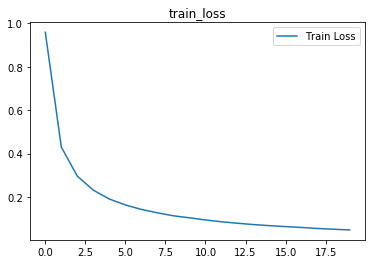

In [48]:
plt.title('train_loss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'], loc='upper right')

In [10]:
# 保存训练模型
PATH = './model/mnist_model.pth'
torch.save(model.state_dict(), PATH)

In [11]:
# 载入模型
model = Net(28 * 28, 300, 100, 10)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>